#### Nicole Vavrukh - CMPT419 A3, Spring 2022

# Prelude: Import data and functions

In [109]:
import pandas as pd # https://pandas.pydata.org/
import numpy as np # https://numpy.org/
import matplotlib.pyplot as plt # https://matplotlib.org/

# https://scikit-learn.org/stable/
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

import copy as cp #https://docs.python.org/3/library/copy.html
import seaborn as sns #https://seaborn.pydata.org/#:~:text=Seaborn%20is%20a%20Python%20data,introductory%20notes%20or%20the%20paper.
from typing import Tuple #https://docs.python.org/3/library/typing.html

import glob #https://docs.python.org/3/library/glob.html
from IPython.display import Image, display #https://ipython.org/

In [110]:
# Taken from https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874
def cross_val_predict(model, kfold : KFold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

    model_ = cp.deepcopy(model)
    
    no_classes = len(np.unique(y))
    
    actual_classes = np.empty([0], dtype=int)
    predicted_classes = np.empty([0], dtype=int)
    predicted_proba = np.empty([0, no_classes])
    

    for train_ndx, test_ndx in kfold.split(X):

        train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

        actual_classes = np.append(actual_classes, test_y)

        model_.fit(train_X, train_y)
        predicted_classes = np.append(predicted_classes, model_.predict(test_X))

        try:
            predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
        except:
            predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)

    return actual_classes, predicted_classes, predicted_proba

def plot_confusion_matrix(actual_classes : np.array, predicted_classes : np.array, sorted_labels : list):
    matrix = confusion_matrix(actual_classes, predicted_classes, labels=sorted_labels)

    # Alter Numbers to Emotion Names
    classDict = {
        0: "angry",
        1: "disgust",
        2: "fear",
        3: "happy",
        4: "neutral",
        5: "sad",
        6: "surprise"
    }
    
    #Source: https://stackoverflow.com/questions/17295776/how-to-replace-elements-in-a-list-using-dictionary-lookup/60038053
    emotionLabels = list((pd.Series(sorted_labels)).map(classDict))
    
    plt.figure(figsize=(12.8,6))
    sns.heatmap(matrix, annot=True, xticklabels=emotionLabels, yticklabels=emotionLabels, cmap="Greens", fmt="g")
    plt.xlabel('Predicted', size = 16); plt.ylabel('Actual', size = 16); plt.title('Confusion Matrix', size = 20)

    plt.show()

In [111]:
def printScoresCV(cvscores, scoringSel):
    print(f"Precision Scores for each fold: {cvscores[f'test_{scoringSel[0]}']}")
    print(f"Recall Scores for each fold: {cvscores[f'test_{scoringSel[1]}']}")
    print(f"Accuracy Scores for each fold: {cvscores[f'test_{scoringSel[2]}']}")
    print(f"F1 Scores for each fold: {cvscores[f'test_{scoringSel[3]}']}\n\n")
    
    avgPrec = np.average(cvscores[f'test_{scoringSel[0]}'])
    avgRecall = np.average(cvscores[f'test_{scoringSel[1]}'])
    avgAcc = np.average(cvscores[f'test_{scoringSel[2]}'])
    avgF1 = np.average(cvscores[f'test_{scoringSel[3]}'])
    
    print(f"Avg Precision Score: {round(avgPrec, 3)}")
    print(f"Avg Recall Score: {round(avgRecall, 3)}")
    print(f"Avg Accuracy Score: {round(avgAcc, 3)}")
    print(f"Avg F1 Score: {round(avgF1, 2)}")
    
def printScoresTest(prec, recall, acc, f1):
    print(f"Precision Score for this test: {round(prec, 3)}")
    print(f"Recall Score for this test: {round(recall, 3)}")
    print(f"Accuracy Score for this test: {round(acc, 3)}")
    print(f"F1 Score for this test: {round(f1, 3)}")

#### Pre-Processing information: 
- The .csv files provided have removed gaze direction and only store AUs and confidence. Thus, no columns need to be removed. Discussion of this choice was explained in A2
- The model will train on data that it considers relatively confident. This value has been selected to be 0.75, or 75%. The testing data does not need to be filtered by confidence as it is not used to train the model. Thus, the FER2013 dataset has removed all removed with confidence < 0.75 but Phoebe has not been altered
- Scaling the data will occur further down in the code

**NOTE:** Both AU_r and AU_Cs are kept as features. This is because performance of the model, as based on cross-validation scores, was found to be better/higher when both were included, rather than removing one of the types. Adding both types of AUs may introduce redundancies, but the OpenFace documentation has stated that AU_c and AU_r were trained on different datasets and with different methods, and thus may not always be consistent in terms of results produced. See [here](https://github.com/TadasBaltrusaitis/OpenFace/wiki/Action-Units) for details. Therefore, combining both results leads to a better final model; while the potential for redundancies exists, the benefit of having different models--which were trained differently--detect the AUs overshadows this negative.

In [112]:
# Import Training data using relative pathing
path = "A3 Data/Fer2013/fer2013.csv"
ferDataFrame = pd.read_csv(path, index_col=0)

# Change emotion name to numbers
emotionDict = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}
# Change fer emotion labels to nums
ferDataFrame = ferDataFrame.replace({"label": emotionDict})
ferDataFrame['label'] = ferDataFrame['label'].astype(int)

# Train only with data having confidence >= 0.75
ferDataFrame.drop(ferDataFrame[ferDataFrame.confidence < 0.75].index, inplace=True)

# Import FRIENDS data using relative pathing
path = "A3 Data/Phoebe/phoebe.csv"
PhoebeDataFrame = pd.read_csv(path, index_col=0)

# Create new col AU28_c so feature list is consistent between Fer and Phoebe
PhoebeDataFrame.insert(loc=ferDataFrame.columns.get_loc("AU28_c"), column="AU28_c", value=0.0)

# Get Labelled subsets of data and convert labels to nums
PhoebeLabelled = PhoebeDataFrame[PhoebeDataFrame.label != "unknown"]
PhoebeLabelled = PhoebeLabelled.replace({"label": emotionDict})

# Get Unknown subset
PhoebeUnknown = PhoebeDataFrame[PhoebeDataFrame.label == "unknown"]

# Task 1 - GMM Cross-Validation
Note: Used [Towards Data Science](https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874) code for assistance

In [113]:
# Number of Clusters = # of Emotions
clusterCount = ferDataFrame["label"].nunique()

# Set up folding and GMM. Set random state for consistency
gmm = GaussianMixture(n_components=clusterCount, random_state = 0)
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
scoringSel = ['precision_macro', 'recall_macro', 'accuracy', 'f1_macro']

# Set up Data + preproccessing
yTrain = ferDataFrame["label"]
xTrain = ferDataFrame.drop("label", axis=1)
xTrain = StandardScaler().fit_transform(xTrain)

# Get macro scores for cross-validation
gmmscores = cross_validate(gmm, xTrain, yTrain, cv=kfold, scoring = scoringSel)
printScoresCV(gmmscores, scoringSel)

Precision Scores for each fold: [0.04799253 0.24222245 0.08727283 0.06642138 0.12690457]
Recall Scores for each fold: [0.08508634 0.20761313 0.06857993 0.06454236 0.15621196]
Accuracy Scores for each fold: [0.1025641  0.18589744 0.07051282 0.07051282 0.1474359 ]
F1 Scores for each fold: [0.06070475 0.19502219 0.07060136 0.0552421  0.12439801]


Avg Precision Score: 0.114
Avg Recall Score: 0.116
Avg Accuracy Score: 0.115
Avg F1 Score: 0.1


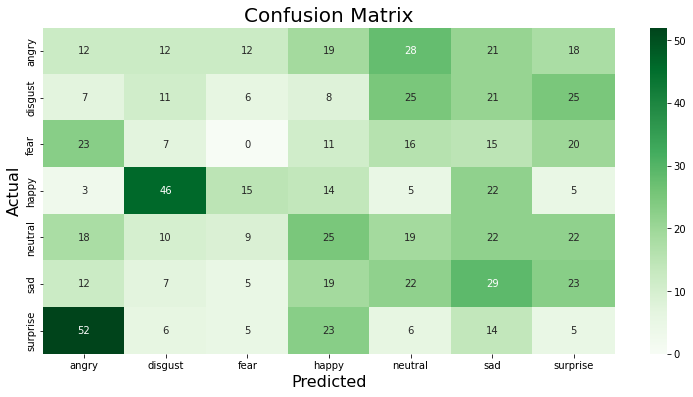

In [114]:
# Get and Print Confusion Matrix, code from https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874
gmmLabels, gmmPredictedLabels, _ = cross_val_predict(gmm, kfold, xTrain, yTrain.to_numpy())
plot_confusion_matrix(gmmLabels, gmmPredictedLabels, yTrain.unique())

As seen above, the GMM Model 5-fold cross-validated on the given data produces the above confusion matrix and the following scoring. Remember, **the closer the value is to 1.0, the better the score**:
- Precision = ~0.11
- Recall = ~0.12
- Accuracy = ~0.12
- F1 = ~0.10

Note: Macro averaging was selected due to the nature of the data, and thus the F1 scores produced do not fall between the recall and precision scores of the folds. See [here](https://stackoverflow.com/questions/66392243/why-macro-f1-measure-cant-be-calculated-from-macro-precision-and-recall) for an in detail discussion on this topic.

# Task 2 - SVM Cross-Validation
Note: Used [Towards Data Science](https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874) code for assistance

In [115]:
# Init Model
svm = svm.SVC(random_state = 0)

# Get scores and print values per fold
svmscores = cross_validate(svm, xTrain, yTrain, cv=kfold, scoring = scoringSel)
printScoresCV(svmscores, scoringSel)

Precision Scores for each fold: [0.46221763 0.46700446 0.41994767 0.50448272 0.40198746]
Recall Scores for each fold: [0.42847658 0.44288893 0.4582483  0.46726345 0.39260636]
Accuracy Scores for each fold: [0.42948718 0.44871795 0.48717949 0.47435897 0.38461538]
F1 Scores for each fold: [0.42038736 0.42971746 0.43483638 0.4583836  0.37727987]


Avg Precision Score: 0.451
Avg Recall Score: 0.438
Avg Accuracy Score: 0.445
Avg F1 Score: 0.42


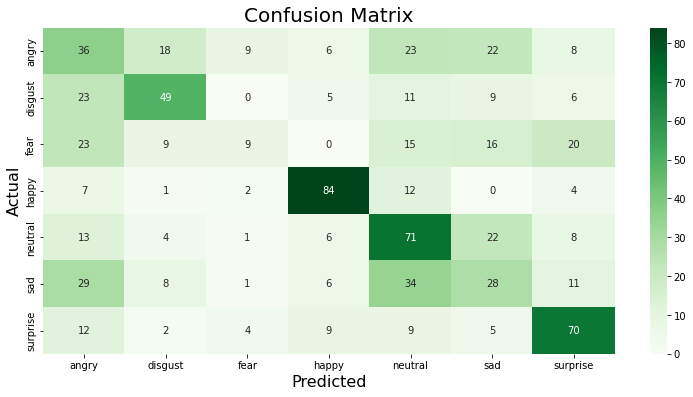

In [116]:
# Get and Print Confusion Matrix, code from https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874
svmLabels, svmPredictedLabels, _  = cross_val_predict(svm, kfold, xTrain, yTrain.to_numpy())
plot_confusion_matrix(svmLabels, svmPredictedLabels, yTrain.unique())

As seen above, the SVM Model 5-fold cross-validated on the given data produces the above confusion matrix and the following scoring. Remember, **the closer the value is to 1.0, the better the score**:
- Precision = ~0.45
- Recall = ~0.44
- Accuracy = ~0.45
- F1 = ~0.42

Note: Macro averaging was selected due to the nature of the data, and thus the F1 scores produced do not fall between the recall and precision scores of the folds. See [here](https://stackoverflow.com/questions/66392243/why-macro-f1-measure-cant-be-calculated-from-macro-precision-and-recall) for an in detail discussion on this topic.

# Task 3 - Comparing SVM and GMM

Looking at the different scores of the 5-fold cross-validation of both models, it is clear there is a visibly optimal choice: SVM. The GMM model struggles, with precision, accuracy, recall, and F1 never reaching above a 0.1 average. On the other hand, the SVM's average values for the same scores are around 0.4. Thus, the SVM's precision, accuracy, recall, and F1 are all at least 4 times greater than the GMM's. 

We can also see this visually in the confusion matrix. A good-performing model will have high values along the diagonals, and low to zero values elsewhere. We can see this is mostly true for SVM and that there were many True Positives (TP), or correctly predicted labels; the GMM however has poor performance along the diagonal, meaning it had very low True Positive (TP) values or correctly predicted labels. Thus, it is clear the SVM is a far better model to predict labels correctly, both in terms of score performance, and in terms of generating TPs.

We will select SVM for these reasons moving forward for the rest of the tasks.

In [117]:
# Train SVM model for prediction
svm.fit(xTrain, yTrain);

# Task 4 - Test/Classify the Phoebe Dataset (Not Unknown)
Note: Used [Towards Data Science](https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874) code for Confusion Matrix help.

Precision Score for this test: 0.284
Recall Score for this test: 0.194
Accuracy Score for this test: 0.322
F1 Score for this test: 0.222


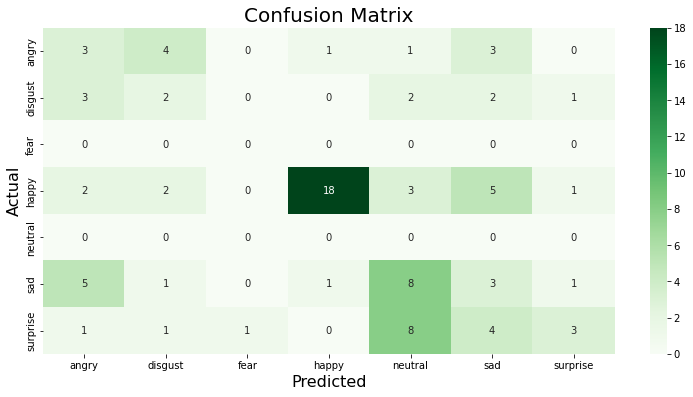

In [118]:
# Set up Data + Preprocessing
PhoebeXTest = PhoebeLabelled.drop("label", axis=1)
PhoebeXTest = StandardScaler().fit_transform(PhoebeXTest)
PhoebeYTest =  PhoebeLabelled["label"]

# Predict/Classify
PhoebePredicted = svm.predict(PhoebeXTest)

# Print macro scores
printScoresTest(precision_score(PhoebeYTest, PhoebePredicted, average='macro'),
                recall_score(PhoebeYTest, PhoebePredicted, average='macro'),
                accuracy_score(PhoebeYTest, PhoebePredicted),
                f1_score(PhoebeYTest, PhoebePredicted, average='macro'))

# Confusion Matrix, code from https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874
plot_confusion_matrix(PhoebeYTest, PhoebePredicted, yTrain.unique())

Using the now trained SVM model to classify known Phoebe images, we can run a test to see the accuracy of our model. We will be using the same scoring functions as in Task 1 and Task 3, and examining the macro versions of precision, recall, accuracy, and F1. There is also a confusion matrix above for visual analysis. Remember, the closer the value is to 1.0, the better the score:

- Precision = ~0.28
- Recall = ~0.19
- Accuracy = ~0.32
- F1 = ~0.22

Clearly, the model did worse on the testing set than the training. However, it is important to note that all values are still above the average scores found in the GMM's cross-validation, so the score is still superior to GMM's. While accuracy remains around 0.4, Precision and Recall get lowered significantly, due to the poor performance on non-Happy labels. This, in turn, impacts the F1 score.

Looking at the confusion matrix, we can see the model performed best on predicting Happy emotions as Happy, and did alright predicting Sad, but otherwise struggled. It also seemed to confuse Sad and Surprise emotions with Neutral and Sad. The Sad, Neutral confusion is something the model struggled with during cross-validation (see Task 2), and Surprise was most commonly mislabeled as Neutral there as well, so this mislabeling is not too unexpected. 

The reasons for this behaviour will be analysed below in Task 5, but simply put: the model is examining mostly AUs and missing the context of these photos within the show, as well as the model being far too simplistic for predicting human emotions.

# Task 5 - Test/Classify the Phoebe Dataset (Unknown)

In [119]:
# Pre-Process
PhoebeXUnknown = PhoebeUnknown.drop("label", axis=1)
PhoebeXUnknownScaled = StandardScaler().fit_transform(PhoebeXUnknown)

# Predict and Classify
UnknownPredict = svm.predict(PhoebeXUnknownScaled)

classDict = {
        0: "angry",
        1: "disgust",
        2: "fear",
        3: "happy",
        4: "neutral",
        5: "sad",
        6: "surprise"
}

# Change number into emotion name. Source: https://stackoverflow.com/questions/17295776/how-to-replace-elements-in-a-list-using-dictionary-lookup/60038053
emotionPredicts = list((pd.Series(UnknownPredict)).map(classDict))

# Add to dataframe
PhoebeXUnknown['Predicted_emotion'] = emotionPredicts
PhoebePredict = PhoebeXUnknown.loc[:, ['Predicted_emotion']]

# Print file vs emotion pairing for quick view
print(PhoebePredict)

          Predicted_emotion
file_name                  
1_01.jpg                sad
8_01.jpg              happy
9_41.jpg              happy
10_51.jpg               sad
11_01.jpg             happy
19_02.jpg               sad
41_06.jpg             angry
52_31.jpg          surprise


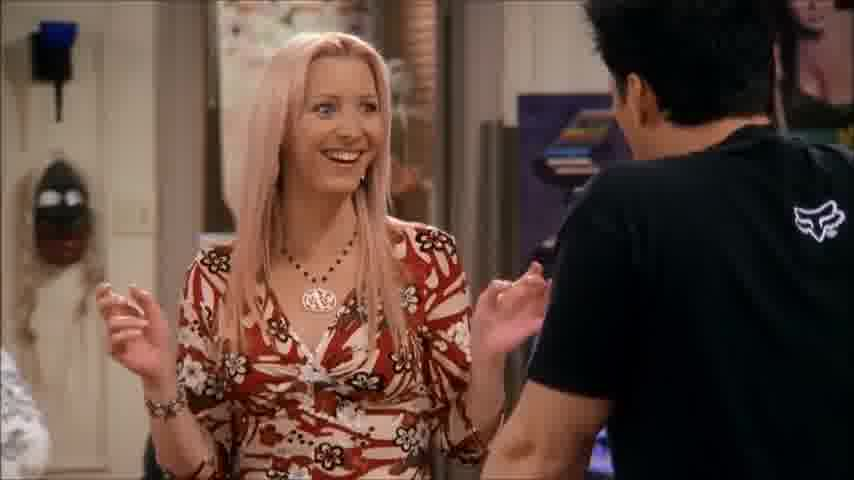

10_51.jpg: Emotion is sad



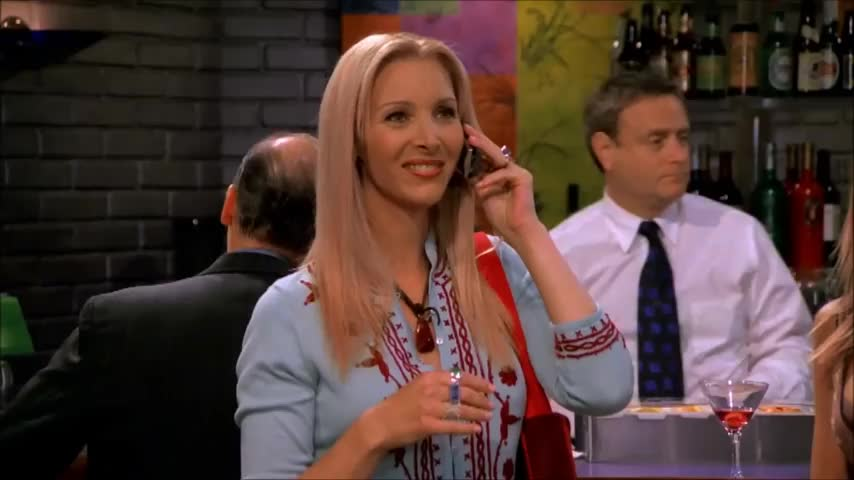

11_01.jpg: Emotion is happy



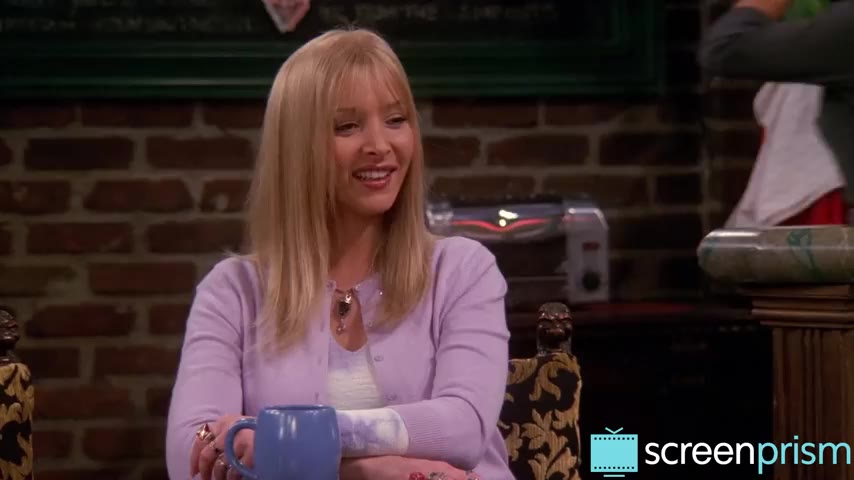

19_02.jpg: Emotion is sad



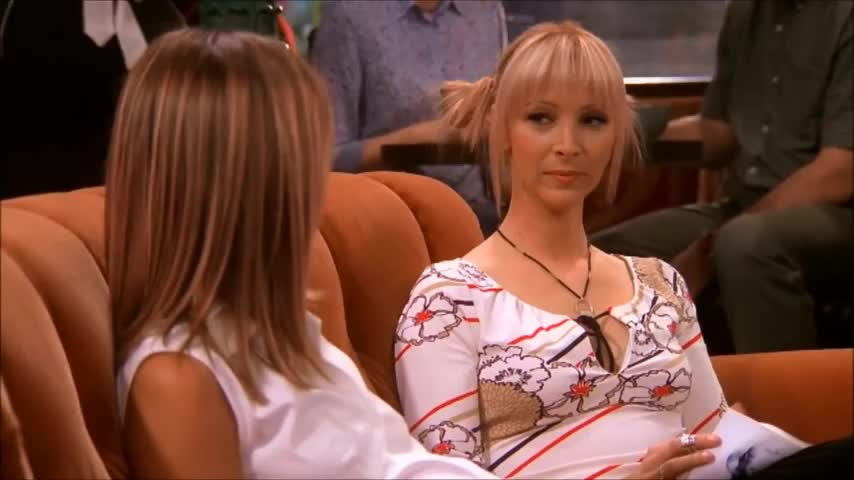

1_01.jpg: Emotion is sad



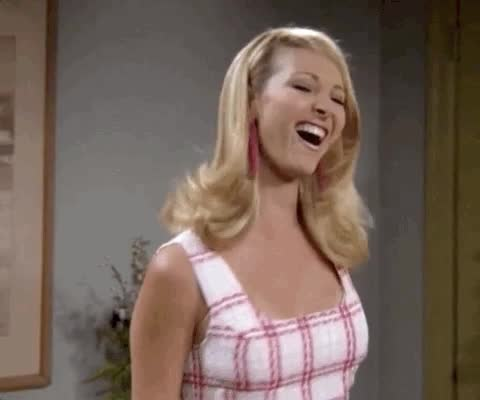

41_06.jpg: Emotion is angry



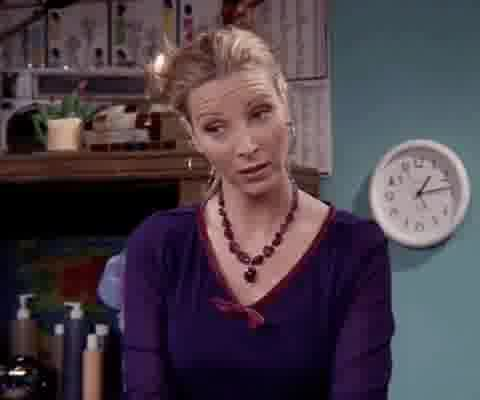

52_31.jpg: Emotion is surprise



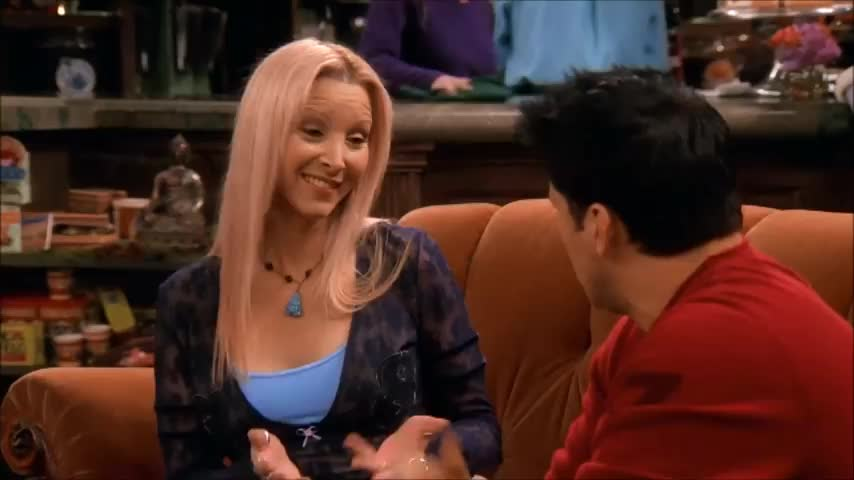

8_01.jpg: Emotion is happy



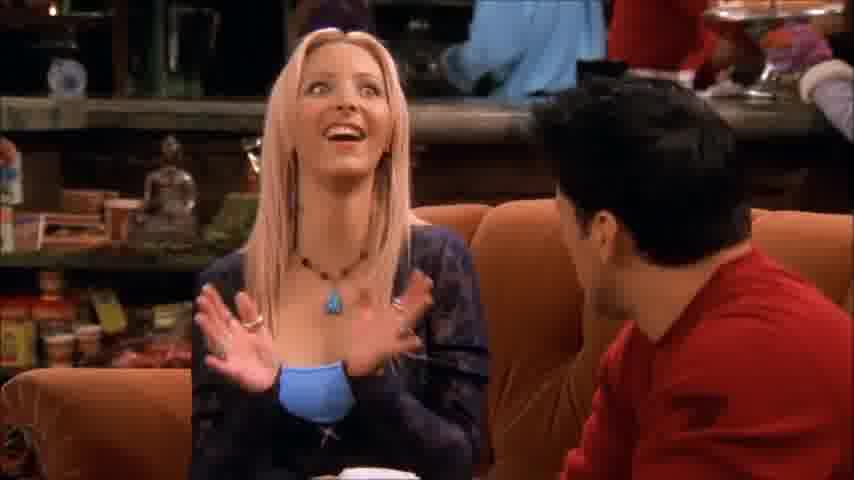

9_41.jpg: Emotion is happy



In [120]:
# Create dictionary for filename key, predicted emotion value for easy display
predictDict = {
    "1_01.jpg": PhoebePredict['Predicted_emotion'].values[0],
    "8_01.jpg": PhoebePredict['Predicted_emotion'].values[1],
    "9_41.jpg": PhoebePredict['Predicted_emotion'].values[2],
    "10_51.jpg": PhoebePredict['Predicted_emotion'].values[3],
    "11_01.jpg": PhoebePredict['Predicted_emotion'].values[4],
    "19_02.jpg": PhoebePredict['Predicted_emotion'].values[5],
    "41_06.jpg": PhoebePredict['Predicted_emotion'].values[6],
    "52_31.jpg": PhoebePredict['Predicted_emotion'].values[7]
}

# Display all unknown pictures and predicted emotion
for img in sorted(glob.glob("A3 Data/Phoebe/images/unknown/*.jpg")):
    display(Image(filename=img, width = 300))
    imgName = img.split('/')[-1]
    print(f'{imgName}: Emotion is {predictDict[imgName]}\n')

The following is a list of image filenames and their corresponding predicted emotion. See above for a visual representation of this list (and the image):
- 1_01.jpg   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; sad
- 8_01.jpg   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; happy
- 9_41.jpg   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; happy
- 10_51.jpg  &nbsp;&nbsp;&nbsp;&nbsp;             sad
- 11_01.jpg  &nbsp;&nbsp;&nbsp;&nbsp;             happy
- 19_02.jpg  &nbsp;&nbsp;&nbsp;&nbsp;             sad
- 41_06.jpg  &nbsp;&nbsp;&nbsp;&nbsp;             angry
- 52_31.jpg  &nbsp;&nbsp;&nbsp;&nbsp;             surprise


## Predicted Label Correction Analysis

#### 10_51.jpg: Emotion is sad

This one is very clearly **incorrect**. If we look at her face, we can see Phoebe is smiling, with slightly widened eyes. Her hands are also slightly up. This should be denoted as either "Happy", as she is very clearly happy, or something far closer to annoyance and anger, as the happiness to see someone is so strong, it seems somewhat forced--like a facade. For simplicity's sake, the correct label will be treated as "Happy".

#### 11_01.jpg: Emotion is happy

This image has the hallmarks of a "happy" image, with a slight smile so should be considered as **correct**. However, given the context of the scenario, as she is holding her phone and is listening to someone, **it would acceptable to label this as Neutral as well**. The reason Neutral would be acceptable is the slight smile is one of someone simply being polite, so perhaps someone engaged in what the speaker on the phone is saying. 

#### 19_02.jpg: Emotion is sad

This image seems to feel as though it can have multiple interpretations. Sadness is a possibility, specifically "Saudade"--a German word meaning melancholic nostalgia. In other words, the emotion of longing for something that is missed and may never return. This can be seen in her slight smile paired with her eyes, which seem to be gazing distincly at something out of frame. However, it is just as likely that Phoebe is simply thinking and chatting with a friend who is lower than her and beyond the image (as indicated by her gaze); perhaps the person is lying down? The second option would be far closer to Neutral. **So, either Neutral or Sad would be correct.**

#### 1_01.jpg: Emotion is sad

Phoebe seems to be far less sad in this photo but rather annoyed at her friend. This can be seen in the narrowed eyes, straight face (and lips), as well as her slackened body posture. Annoyance is a weak form of Anger, so **this label is incorrect and should instead be "Anger".**

#### 41_06.jpg: Emotion is angry

This image is very clearly **incorrectly labeled as anger**. However, besides not being anger, it is unclear in the image what is occurring. Most likely, Phoebe seems to be in a higher valence mood, and seems to be singing, with her eyes shut and mouth ajar as if vocalizing loudly. **Of the possible 7 labels, this image would have to be under "Happy" instead.**

#### 52_31.jpg: Emotion is surprise

This image is actually quite interesting in that no label from the given 7 seems to perfectly encapsulate the emotion shown. Phoebe seems to be intrigued or interested in something. This could fall under Surprise--but is far too low in arousal to be considered such. However, of all the labels given, This "interest" or "curiosity" seems best fit surprise, and thus, while not perfectly fitting, **Surprise should be considered correct.**

#### 8_01.jpg: Emotion is happy

In this photo, Phoebe seemed to have told a story and ended it by telling the listener about the weird circumstances that have befallen her. In other words, she has explained a somewhat odd story with an odder and possibly funny ending. This can be seen in how she holds her hand, along with her slanted smile and eyebrows. Happy does not seem to fit this, so the **predicted label was incorrect. Again, none of the possible 7 emotions seem to fit, but the closest appears to be "Neutral".**

#### 9_41.jpg: Emotion is happy

This image seems to be from the same scene as 8_01, but now Phoebe seems to be mimicking someone, hands doing jazz-hands in exaggeration, while her eyes are extremely wide, her head is tilted back, and her mouth is turned into a forced smile. While the face indicates happiness, examining the rest of her body shows she is simply making a joke of someone or perhaps showing her lack of happiness through sarcasm. **Regardless, happiness is not the right label here and a better fitting one would be "anger", as most people who mimic others in this manner are upset at them.**

#### In Summary, 3/9 emotions were labeled what the experimenter deemed as correct given the limits of the category choice. However, there are issues with the model, input data, etc. which have led to this accuracy rate. They have been slightly mentioned above, but a deeper dive can be found below.

## Discussion of Accuracy and Limitations of Model

As discussed above, we have found this model has a low accuracy for the unknown data and did alright with known data. As this model is planned to be used on real-life data with no known label, it is important to discuss why the accuracy was so poor.

One of the largest limitations is the input data. The .csv files given only examine the AUs within the face. Not only can these be incorrect, but they can also be misleading, and other, stronger indicators may exist in other parts of the image. By examining only AUs, much of the context a human is able to identify is lost and thus the model begins to lose accuracy with real-world data. There are even points where the experimenter/programmer is unsure of the correct emotion due to the lack of context within the images--and this is something given all the context available from the static images, rather than just the AUs. In the Unknown Phoebe dataset, there were several images where the context was not detected by just AUs, or simply were not able to be given/shown within the entirely of the image.

Another large issue is the simplicity of the labels. The 6 basic emotions (and Neutral) are simply too basic to be useful in examining what a human may be experiencing emotionally in an image. Sadness is indeed an emotion, but can be delved deeper (such as Sorrow, Regret, etc.) and may also be combined with other emotions to create new ones (Sad + Happy = Nostalgia, Surprise + Happy = Excitement, etc.). Additionally, the amount someone is feeling may also indicate a different emotion (small levels of surprise = curiousity, etc.). This model takes absolutely zero of this nuance found within the human condition and rather attempts to decode this complex system into 7 categories. In almost half the images, none of the 7 labels were perfect fits for them. Several felt like they fit more than one, while others felt like they fit none of them. If this model were to consider more emotions, and the subcategories within them--and of course increased the dataset for training--it very likely would have performed better when compared to a human's labeling. 